In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Data modelling and fitting

- Often we want to understand data by fitting a model, a function, to it. This can be 1D, 2D, 3D, 4D, .....
- We might know the underlying process and thus know the function to pick. E.g.
    - growth processes: exponential functions
    - physical processes with known solutions (radioactive decay)
    - or we have data and try different functions to understand the underlying laws
    
Fit functions have parameters to fit, e.g.

$ f(x) = ax + b$

has the two parameters $a$ and $b$.

#### Goodness of fit

- How can measure how good a fit is?
- The most widely used measure is $\chi^2$. 
- It measures the quadratic deviation from the mean.
- For a data set $(x_i, y_i)$ and a fit function $f(x)$ it is calculated

$\chi^2 = \sum_{i=1}^N \left(\frac{y_i - f(x_i)}{\sigma_i}\right)^2$

- $\sigma_i$ represents the uncertainty of observation $y_i$.
- Sometimes it is known, e.g. measurement errors in labs, but often it is not.
- If $y_i$ represents counts the uncertainty will be described by the Poisson statistics. The variance is equal to the expected value and we can set $\sigma_i^2 = y_i$ and

$\chi^2 = \sum_{i=1}^N \frac{(y_i - f(x_i))^2}{y_i}$

$\chi^2$ has a probability distribution.

$P(\chi^2) = (\chi^2)^{(\nu -2)/2} \exp\left(-\frac{\chi^2}{2}\right)$

$\nu$ is the number of *degrees of freedom* of a model. It is $\nu = N-p$ with $p$ being the number of parameters. 

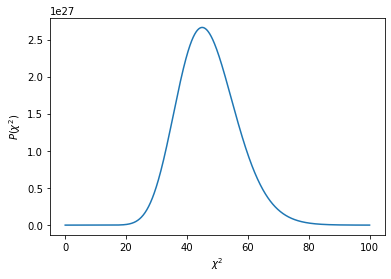

In [2]:
ndata = 50
npara = 3
nu = ndata - npara

chi2 = np.linspace(0.0, 2.0*ndata, 1000)
prob = chi2**((nu - 2) / (2)) * np.exp(-chi2/2)

plt.figure()
plt.plot(chi2, prob)

plt.xlabel("$\chi^2$")
plt.ylabel("$P(\chi^2)$")
plt.show()

- The probability is highest for $\chi^2 \approx \nu$. Thus sometimes the reduced $\chi^2_r$ which is $\frac{\chi^2}{\nu}$ is given. A good fit should have a value of $\approx 1$.
- A big danger is overfitting. Adding more parameters *always* reduces $\chi^2$, but that can be meaningless
- Formal criteria to assess whether an improvment is meaningful can be derived using the AIC (Akaika information criterion) or BIC (Bayes information criterion)
- Rule of thumb: if the reduced $\chi^2_r$ has a value of about 1 it is time to stop. Optical inspection also important.
- The maximum number of parameters which can be fitted to $N$ datapoints is $p=N-1$. 
- *Not* that this would be a meaningful fit.

Properties of th $\chi^2$ distribution

$\overline{\chi^2} = \nu$,   Var($\chi^2) = 2\nu$

Thus for a good model we would expect $\chi^2 = \nu \pm \sqrt{2\nu}$.


### Least square fitting

Building on the idea of $\chi^2$ as a measure of *goodness of fit* are methods to least square minimisation.

- given a data set of $N$ points $(x_i, y_i)$
- fit a function $f(x, \beta)$. $\beta$ is the vector of free parameters.
- Find the set of $\beta$ which minimises

$\chi^2 = \sum_{i=1}^N \left(\frac{y_i - f(x_i)}{\sigma_i}\right)^2$

or if we do not have estimates of $\sigma_i$

$\chi^2 = \sum_{i=1}^N (y_i - f(x_i))^2$

- Least square fitting can rarely done by hand or simple spreadsheet work. 
- Note that the standard formula for fitting a straight line is derived from least square fitting.
- Fitting can be hard and CPU intensive.

`curvefit()` least square fit function in `scipy.optim`.

Function for the fitting. The function has the form *independend variable* and then a *list of parameters* to be fitted.

In [3]:
def linfunc(x, a, b):
    """ Function for fitting
        x: independent variable
        a, b: parameters to be fitted
    """
    
    y = a*x + b
    
    return y

Import `scipy.optim` and do the fitting.

`curvefit()` returns two arrays
- An array of the best fit parameters.
- And the variance-covariance matrix

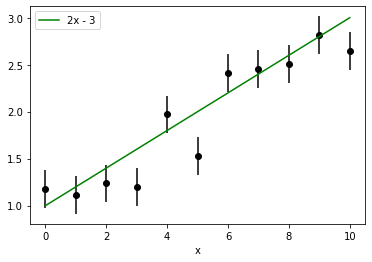

In [10]:
# calculate points of linear function
x = np.linspace(0.0, 10.0, 11)
y = linfunc(x, 0.2, 1.0)
# add some normal distributed random noise
y = y + np.random.normal(0.0, 0.2, 11)
# error array
errors = 0.2 * np.ones_like(x)

xf = np.linspace(0.0, 10.0, 101) # points for line plot

# points and errorbars
plt.plot(x, y, "ok")
plt.errorbar(x, y, errors, color="black", linestyle="none")

# plot fit and input function
plt.plot(xf, linfunc(xf, 0.2, 1.0), "g", label="2x - 3")

plt.xlabel("x")
plt.legend()
plt.show()


In [11]:
import scipy.optimize as opt

# do the fitting
# curvefit expects the argument list of the fit function to be (x, p1, p2, p3, p4, ....)
param, pcovar = opt.curve_fit(linfunc, x, y)
# specify errors: sigma=errors, absolute_sigma=True
# specify start value p0=(0,0)

# list of parameters
print("parameters:", param)
# variance-covariance matrix
print()
print("covariance-matrix", pcovar)

# one can get the std. dev. this way
# np.diag() extracts the diagonal of a matrix
sigma = np.sqrt(np.diag(pcovar))

print()
print(f"a = {param[0]:5.3f} +/- {sigma[0]:5.3f}")
print(f"b = {param[1]:5.3f} +/- {sigma[1]:5.3f}")

parameters: [0.18989315 0.96410626]

covariance-matrix [[ 0.00057832 -0.00289162]
 [-0.00289162  0.02024133]]

a = 0.190 +/- 0.024
b = 0.964 +/- 0.142


In [16]:
# use the known errors for fitting
param, pcovar = opt.curve_fit(linfunc, x, y, sigma=errors)
# specify errors: sigma=errors, absolute_sigma=True

print()
print(f"a = {param[0]:5.3f} +/- {sigma[0]:5.3f}")
print(f"b = {param[1]:5.3f} +/- {sigma[1]:5.3f}")


a = 0.190 +/- 0.024
b = 0.964 +/- 0.142


#### Recommendation

- if errors are known use them for fitting. Keep `absolute_sigma=False` (default)
- if errors are not known `curve_fit()` does a good estimate

Python offers a nifty notation to transfer an array to an argument list.

In [15]:
print(param)
print()
print(*param)

[0.18989315 0.96410625]

0.1898931486805675 0.9641062538824176


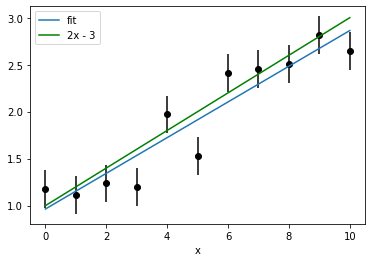

In [18]:
# produce a plot of points and fit
plt.figure()

# points and errorbars
plt.plot(x, y, "ok")
plt.errorbar(x, y, errors, color="black", linestyle="none")

# plot fit and input function
plt.plot(xf, linfunc(xf, *param), label="fit")     # note the asterisk
plt.plot(xf, linfunc(xf, 0.2, 1.0), "g", label="2x - 3")

plt.xlabel("x")
plt.legend()
plt.show()


#### How to visualise the error range?

Plot lines for all combinations $a\pm \sigma_a$ and $b\pm \sigma_b$

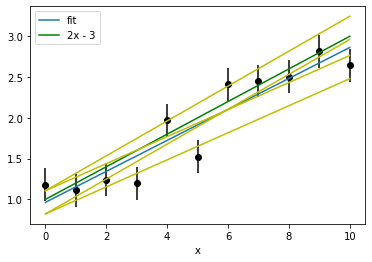

In [21]:
# produce a plot of points and fit
plt.figure()

# points and errorbars
plt.plot(x, y, "ok")
plt.errorbar(x, y, errors, color="black", linestyle="none")

# plot fit and input function
plt.plot(xf, linfunc(xf, *param), label="fit")     # note the asterisk
plt.plot(xf, linfunc(xf, 0.2, 1.0), "g", label="2x - 3")

# plot all combinations
a = param[0]
sa = sigma[0]
b = param[1]
sb = sigma[1]
plt.plot(xf, linfunc(xf, a+sa, b+sb), "y-")
plt.plot(xf, linfunc(xf, a+sa, b-sb), "y-")
plt.plot(xf, linfunc(xf, a-sa, b+sb), "y-")
plt.plot(xf, linfunc(xf, a-sa, b-sb), "y-")

plt.xlabel("x")
plt.legend()
plt.show()


Function to return an evelope of lower and upper limits for all combinations of parameters and sigmas.

In [22]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   


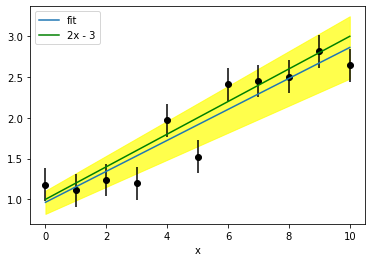

In [24]:
# produce a plot of points and fit
plt.figure()

# points and errorbars
plt.plot(x, y, "ok")
plt.errorbar(x, y, errors, color="black", linestyle="none")

# plot fit and input function
plt.plot(xf, linfunc(xf, *param), label="fit")     # note the asterisk
plt.plot(xf, linfunc(xf, 0.2, 1.0), "g", label="2x - 3")

# plot enveope of all combinations
low, up = err_ranges(xf, linfunc, param, sigma)
plt.fill_between(xf, low, up, color="yellow", alpha=0.7)

plt.xlabel("x")
plt.legend()
plt.show()


#### Fit of radioactive decay

The decay rate of radioactive material is described by

$N = N_0\,\exp(t/\tau)$

with $N_0$ begin the initial count rate, $\tau$ the characteristic time. The mean half lifetime is $t_{1/2} = \ln(2)\,\tau$.

Count rates were measured for iodine-131 and are available in `iodine_counts.csv`. Fit the decay law to determine the half life. 

             days      counts
count  720.000000  720.000000
mean    15.000000  128.437500
std      8.666266   90.983876
min      0.020833   16.000000
25%      7.510417   51.750000
50%     15.000000  100.000000
75%     22.489583  190.000000
max     29.979167  368.000000


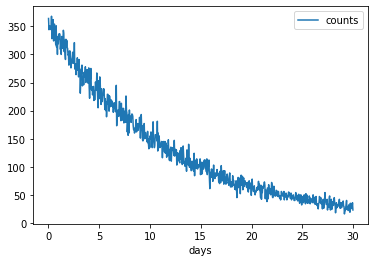

In [26]:
import numpy as np
import pandas as pd
import scipy.optimize as opt

import matplotlib.pyplot as plt
%matplotlib inline

def decay(t, n0, halflife):
    """ 
    Returns the exponential function for radioactive decay. 
    n0: initial number of radioactive nuclei
    halflife: mean half life of the nuclei
    """
    
    # # decay constant
    lam = np.log(2.0) / halflife
    
    n = n0 * np.exp(-lam*t)
    
    return n


df_counts = pd.read_csv("iodine_counts.csv")
print(df_counts.describe())

df_counts.plot("days", "counts")
plt.show()

df_counts["sigma"] = np.sqrt(df_counts["counts"])



In [27]:
param, covar = opt.curve_fit(decay, df_counts["days"], df_counts["counts"], 
                    sigma=df_counts["sigma"], absolute_sigma=False)

print(np.sqrt(np.diag(covar)))
sigma = np.sqrt(np.diag(covar))
print(sigma)
print()
print(f"N0 = {param[0]:5.1f} +/- {sigma[0]:3.1f}")
print(f"t_1/2 = {param[1]:4.2f} +/- {sigma[1]:4.2f}")

[1.85285456 0.04099071]
[1.85285456 0.04099071]

N0 = 356.7 +/- 1.9
t_1/2 = 8.03 +/- 0.04


Accurate value: $t_{1/2} = 8.0252$

In [28]:
df_counts["fit"] = decay(df_counts["days"], *param)

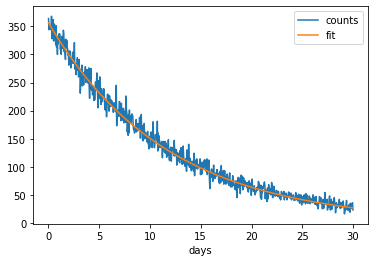

In [29]:
df_counts.plot("days", ["counts", "fit"])
plt.show()

    Year                   GDP
0   1960    73233967692.102798
1   1961    77741965703.354401
2   1962      81247564156.8246
3   1963    86561961812.324905
4   1964    94407558351.161606
..   ...                   ...
56  2016   2722851958486.22998
57  2017  2699016715111.390137
58  2018  2900791442554.060059
59  2019  2878673912414.439941
60  2020  2759804061837.069824

[61 rows x 2 columns]
Index(['Year', 'GDP'], dtype='object')


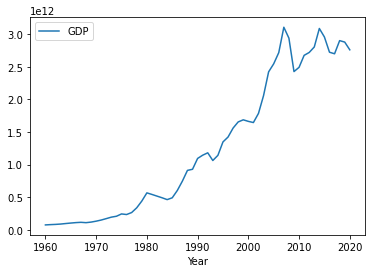

In [32]:
df_gdp = pd.read_csv("UK_transpose.csv")
df_gdp = df_gdp.transpose()
df_gdp.columns = ["GDP"]
df_gdp = df_gdp.iloc[4:]
df_gdp = df_gdp.iloc[:-1]
df_gdp = df_gdp.reset_index()
df_gdp = df_gdp.rename(columns={"index": "Year"})
print(df_gdp)
print(df_gdp.columns)

df_gdp.plot("Year", "GDP")
plt.show()

In [33]:
def exponential(t, n0, g):
    """Calculates exponential function with scale factor n0 and growth rate g."""
    
    t = t - 1960.0
    f = n0 * np.exp(g*t)
    
    return f

In [34]:
print(type(df_gdp["Year"].iloc[1]))
df_gdp["Year"] = pd.to_numeric(df_gdp["Year"])
print(type(df_gdp["Year"].iloc[1]))
param, covar = opt.curve_fit(exponential, df_gdp["Year"], df_gdp["GDP"], 
                             p0=(73233967692.102798, 0.03))

<class 'str'>
<class 'numpy.int64'>


No good ways to derive errors of GDP values. Note that the year-by-year data are highly correlated. Let `curve_fit` find the errors.

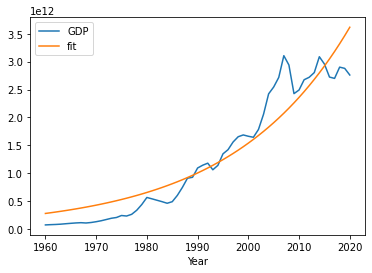

In [35]:
df_gdp["fit"] = exponential(df_gdp["Year"], *param)

df_gdp.plot("Year", ["GDP", "fit"])
plt.show()

#### The logistic function

$L(t) = \frac{N}{1-\exp(-g(t-t_0))}$

![Logistic function](Logistic.png)

This function describes exponential growth which levels off. 
- For small $t$ it behaves like $\exp(g\,t)$.
- For very large values it asymptotically approaches $N$.
- $t_0$ is the turning point at $N/2$.

In [36]:
def logistic(t, n0, g, t0):
    """Calculates the logistic function with scale factor n0 and growth rate g"""
    
    f = n0 / (1 + np.exp(-g*(t - t0)))
    
    return f

In [37]:
param, covar = opt.curve_fit(logistic, df_gdp["Year"], df_gdp["GDP"], 
                             p0=(3e12, 0.03, 2000.0))

parameters: [3.17426305e+12 1.21272926e-01 1.99685846e+03]
std. dev. [1.07281654e+11 8.06837204e-03 8.49071431e-01]


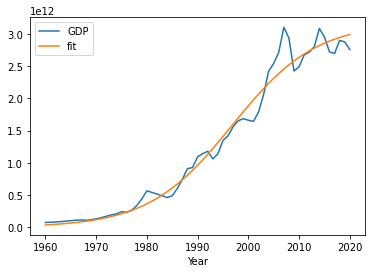

In [38]:
sigma = np.sqrt(np.diag(covar))
print("parameters:", param)
print("std. dev.", sigma)

df_gdp["fit"] = logistic(df_gdp["Year"], *param)

df_gdp.plot("Year", ["GDP", "fit"])
plt.show()

Try out with some guessing of values
- What is the maxium ($=N$)
- Where is the turning point ($=t_0$)
- What is a reasonable growth rate over the decades ($=g$)

Plot the function and refine if necessary. It does not have to be a good fit, just a rough approximation.

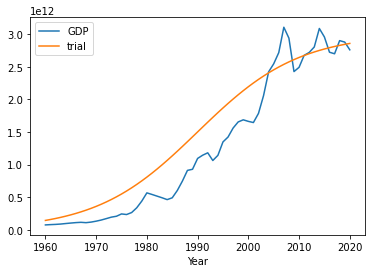

In [39]:
df_gdp["trial"] = logistic(df_gdp["Year"], 3e12, 0.10, 1990)

df_gdp.plot("Year", ["GDP", "trial"])
plt.show()

In [40]:
year = np.arange(1960, 2031)
print(year)
forecast = logistic(year, *param)

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029
 2030]


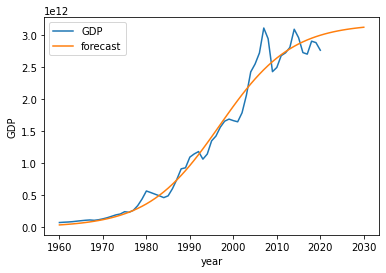

In [41]:
plt.figure()
plt.plot(df_gdp["Year"], df_gdp["GDP"], label="GDP")
plt.plot(year, forecast, label="forecast")

plt.xlabel("year")
plt.ylabel("GDP")
plt.legend()
plt.show()

In [42]:
low, up = err_ranges(year, logistic, param, sigma)


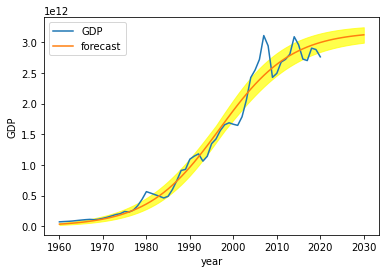

In [43]:
plt.figure()
plt.plot(df_gdp["Year"], df_gdp["GDP"], label="GDP")
plt.plot(year, forecast, label="forecast")

plt.fill_between(year, low, up, color="yellow", alpha=0.7)
plt.xlabel("year")
plt.ylabel("GDP")
plt.legend()
plt.show()

In [44]:
print(err_ranges(2030, logistic, param, sigma))

(2989713481664.0737, 3241602490128.607)


### How do deal with outliers?

- Many real world datasets contain outliers = values deviating a lot more than expected from a normal distribution.
- Sensors can produce faulty measurements. Values entered by hand can be wrong.
- Or underlying distribution have fat tails.

![FTSE 100](ftse_land.png)

Let's again create points and fit them with a linear function.

       x   measure
0    0.0  1.071306
1    0.5  0.984356
2    1.0  1.327005
3    1.5  1.495325
4    2.0  1.319034
5    2.5  1.483367
6    3.0  1.725017
7    3.5  1.578605
8    4.0  1.974079
9    4.5  1.871546
10   5.0  2.018339
11   5.5  2.187500
12   6.0  2.009294
13   6.5  2.401495
14   7.0  2.420601
15   7.5  2.512853
16   8.0  2.475692
17   8.5  2.666381
18   9.0  2.797572
19   9.5  2.810430
20  10.0  2.920546


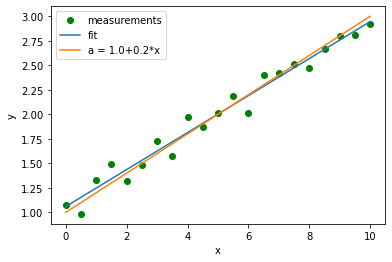

In [45]:
def linear(x, a, b):
    """ Simple linear function calculating a + b*x. """
    f = a + b*x
    
    return f


# create a few points with normal distributed random errors
xarr = np.linspace(0.0, 10.0, 21)
yarr = linear(xarr, 1.0, 0.2)
ymeasure = yarr + np.random.normal(0.0, 0.10, len(yarr))

# create a list of x-y pairs for conversion to a dataframe
lin_list = []
for x, ym in zip(xarr, ymeasure):
    lin_list.append([x, ym])
# do the conversion    
df_lin = pd.DataFrame(lin_list, columns=["x", "measure"])
print(df_lin)

# fit the data
param, covar = opt.curve_fit(linear, df_lin["x"], df_lin["measure"])

# plot the result
plt.figure()
plt.plot(df_lin["x"], df_lin["measure"], "go", label="measurements")
plt.plot(df_lin["x"], linear(df_lin["x"], *param), label="fit")
plt.plot(df_lin["x"], linear(df_lin["x"], 1.0, 0.2), label="a = 1.0+0.2*x")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

       x   measure       fit
0    0.0  1.071306  1.216800
1    0.5  0.984356  1.282038
2    1.0  1.327005  1.347276
3    1.5  1.495325  1.412514
4    2.0  1.319034  1.477752
5    2.5  1.483367  1.542990
6    3.0  1.725017  1.608228
7    3.5  1.578605  1.673466
8    4.0  1.974079  1.738704
9    4.5  1.871546  1.803942
10   5.0  2.018339  1.869180
11   5.5  2.187500  1.934417
12   6.0  2.009294  1.999655
13   6.5  2.401495  2.064893
14   7.0  2.420601  2.130131
15   7.5  2.512853  2.195369
16   8.0  2.475692  2.260607
17   8.5  2.666381  2.325845
18   9.0  0.000000  2.391083
19   9.5  2.810430  2.456321
20  10.0  2.920546  2.521559


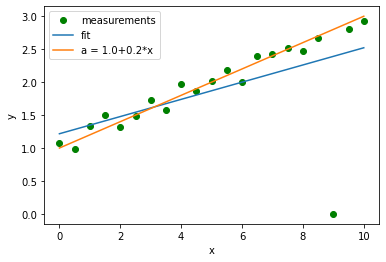

In [46]:
# add one outlier
df_lin["measure"].iloc[18] = 0.0

param, covar = opt.curve_fit(linear, df_lin["x"], df_lin["measure"])
df_lin["fit"] = linear(df_lin["x"], *param)

print(df_lin)
plt.figure()
plt.plot(df_lin["x"], df_lin["measure"], "go", label="measurements")
plt.plot(df_lin["x"], linear(df_lin["x"], *param), label="fit")
plt.plot(df_lin["x"], linear(df_lin["x"], 1.0, 0.2), label="a = 1.0+0.2*x")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

For normal distributed values outlies $\ge 3\sigma$ are rare: $P=0.23\%$ (i.e. 1 in 435).

Deviation is measured by the $z$ score

$z = \frac{x - \overline{x}}{\sigma}$

It is common practise to exclude points with $|z| \ge 3$ from the fit. How to procide?
- Do a fit with all points.
- Calculate the value of the fit function for every point.
- Calculate the differences between measurements and fit values.
- Calculate the std. deviation of the difference.
- Calculate the $z$ score.
- Exclude points with $|z| \ge 3$.
- Repeat until no more points with $|z|>3$ are found.

First calculations of $z$ scores

In [47]:
df_lin["diff"] = df_lin["measure"] - df_lin["fit"]
sigma = df_lin["diff"].std()
print(sigma)

df_lin["z"] = abs(df_lin["diff"] / sigma)
print(df_lin)

0.5821236079972695
       x   measure       fit      diff         z
0    0.0  1.071306  1.216800 -0.145494  0.249937
1    0.5  0.984356  1.282038 -0.297683  0.511373
2    1.0  1.327005  1.347276 -0.020271  0.034823
3    1.5  1.495325  1.412514  0.082811  0.142256
4    2.0  1.319034  1.477752 -0.158718  0.272654
5    2.5  1.483367  1.542990 -0.059623  0.102423
6    3.0  1.725017  1.608228  0.116789  0.200626
7    3.5  1.578605  1.673466 -0.094861  0.162957
8    4.0  1.974079  1.738704  0.235375  0.404338
9    4.5  1.871546  1.803942  0.067604  0.116134
10   5.0  2.018339  1.869180  0.149160  0.256234
11   5.5  2.187500  1.934417  0.253082  0.434757
12   6.0  2.009294  1.999655  0.009638  0.016557
13   6.5  2.401495  2.064893  0.336601  0.578230
14   7.0  2.420601  2.130131  0.290470  0.498983
15   7.5  2.512853  2.195369  0.317484  0.545390
16   8.0  2.475692  2.260607  0.215085  0.369483
17   8.5  2.666381  2.325845  0.340537  0.584990
18   9.0  0.000000  2.391083 -2.391083  4.107517
1

Exclude points

In [48]:
df_lin = df_lin[df_lin["z"]<3.0].copy()
print(df_lin)

       x   measure       fit      diff         z
0    0.0  1.071306  1.216800 -0.145494  0.249937
1    0.5  0.984356  1.282038 -0.297683  0.511373
2    1.0  1.327005  1.347276 -0.020271  0.034823
3    1.5  1.495325  1.412514  0.082811  0.142256
4    2.0  1.319034  1.477752 -0.158718  0.272654
5    2.5  1.483367  1.542990 -0.059623  0.102423
6    3.0  1.725017  1.608228  0.116789  0.200626
7    3.5  1.578605  1.673466 -0.094861  0.162957
8    4.0  1.974079  1.738704  0.235375  0.404338
9    4.5  1.871546  1.803942  0.067604  0.116134
10   5.0  2.018339  1.869180  0.149160  0.256234
11   5.5  2.187500  1.934417  0.253082  0.434757
12   6.0  2.009294  1.999655  0.009638  0.016557
13   6.5  2.401495  2.064893  0.336601  0.578230
14   7.0  2.420601  2.130131  0.290470  0.498983
15   7.5  2.512853  2.195369  0.317484  0.545390
16   8.0  2.475692  2.260607  0.215085  0.369483
17   8.5  2.666381  2.325845  0.340537  0.584990
19   9.5  2.810430  2.456321  0.354109  0.608306
20  10.0  2.920546  

In [49]:
sigma = df_lin["diff"].std()
print(sigma)

df_lin["z"] = abs(df_lin["diff"] / sigma)
print(df_lin)

0.2018620146843805
       x   measure       fit      diff         z
0    0.0  1.071306  1.216800 -0.145494  0.720761
1    0.5  0.984356  1.282038 -0.297683  1.474684
2    1.0  1.327005  1.347276 -0.020271  0.100420
3    1.5  1.495325  1.412514  0.082811  0.410235
4    2.0  1.319034  1.477752 -0.158718  0.786271
5    2.5  1.483367  1.542990 -0.059623  0.295364
6    3.0  1.725017  1.608228  0.116789  0.578560
7    3.5  1.578605  1.673466 -0.094861  0.469931
8    4.0  1.974079  1.738704  0.235375  1.166019
9    4.5  1.871546  1.803942  0.067604  0.334903
10   5.0  2.018339  1.869180  0.149160  0.738919
11   5.5  2.187500  1.934417  0.253082  1.253738
12   6.0  2.009294  1.999655  0.009638  0.047748
13   6.5  2.401495  2.064893  0.336601  1.667482
14   7.0  2.420601  2.130131  0.290470  1.438951
15   7.5  2.512853  2.195369  0.317484  1.572779
16   8.0  2.475692  2.260607  0.215085  1.065504
17   8.5  2.666381  2.325845  0.340537  1.686977
19   9.5  2.810430  2.456321  0.354109  1.754214
2

       x   measure       fit      diff         z
0    0.0  1.071306  1.061999 -0.145494  0.720761
1    0.5  0.984356  1.155816 -0.297683  1.474684
2    1.0  1.327005  1.249632 -0.020271  0.100420
3    1.5  1.495325  1.343449  0.082811  0.410235
4    2.0  1.319034  1.437266 -0.158718  0.786271
5    2.5  1.483367  1.531082 -0.059623  0.295364
6    3.0  1.725017  1.624899  0.116789  0.578560
7    3.5  1.578605  1.718715 -0.094861  0.469931
8    4.0  1.974079  1.812532  0.235375  1.166019
9    4.5  1.871546  1.906349  0.067604  0.334903
10   5.0  2.018339  2.000165  0.149160  0.738919
11   5.5  2.187500  2.093982  0.253082  1.253738
12   6.0  2.009294  2.187798  0.009638  0.047748
13   6.5  2.401495  2.281615  0.336601  1.667482
14   7.0  2.420601  2.375431  0.290470  1.438951
15   7.5  2.512853  2.469248  0.317484  1.572779
16   8.0  2.475692  2.563065  0.215085  1.065504
17   8.5  2.666381  2.656881  0.340537  1.686977
19   9.5  2.810430  2.844514  0.354109  1.754214
20  10.0  2.920546  

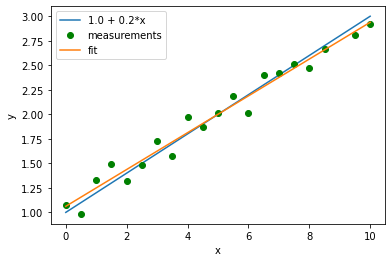

In [50]:
param, covar = opt.curve_fit(linear, df_lin["x"], df_lin["measure"])
df_lin["fit"] = linear(df_lin["x"], *param)


print(df_lin)
plt.figure()
plt.plot(df_lin["x"], linear(df_lin["x"], 1.0, 0.2), label="1.0 + 0.2*x")
plt.plot(df_lin["x"], df_lin["measure"], "go", label="measurements")
plt.plot(df_lin["x"], df_lin["fit"], label="fit")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()